# 🧠 DBSI-Optimized: Tutorial Notebook

**Diffusion Basis Spectrum Imaging - High Performance Implementation**

Questo notebook ti guida nell'utilizzo della toolbox DBSI-Optimized.

---

## 1. Data Loading



In [1]:
import dbsi_optimized
import numpy as np
import matplotlib.pyplot as plt
from dbsi_optimized.preprocessing import load_dwi_data

dwi_file='/Users/francescoguarnaccia/Desktop/Data/DWI Project/DWI Trials/DWI_data_trials/000019/20250325/prep/DWITE106P2sense19nsoppyAPP_preprocessed_N4.nii.gz'
bvec_file='/Users/francescoguarnaccia/Desktop/Data/DWI Project/DWI Trials/DWI_data_trials/000019/20250325/prep/DWITE106P2sense19nsoppyAPP_corrected.bvec'
bval_file='/Users/francescoguarnaccia/Desktop/Data/DWI Project/DWI Trials/DWI_data_trials/000019/20250325/prep/DWITE106P2sense19nsoppyAPP_corrected.bval'
mask_file='/Users/francescoguarnaccia/Desktop/Data/DWI Project/DWI Trials/DWI_data_trials/000019/20250325/prep/DWITE106P2sense19nsoppyAPP_preprocessed_brain_mask.nii.gz'

dwi, bvals, bvecs, mask, affine = load_dwi_data(dwi_file, bval_file, bvec_file, mask_file)

Loading DWI: /Users/francescoguarnaccia/Desktop/Data/DWI Project/DWI Trials/DWI_data_trials/000019/20250325/prep/DWITE106P2sense19nsoppyAPP_preprocessed_N4.nii.gz
  ✓ Shape: (112, 112, 78, 92)
Loading gradients: /Users/francescoguarnaccia/Desktop/Data/DWI Project/DWI Trials/DWI_data_trials/000019/20250325/prep/DWITE106P2sense19nsoppyAPP_corrected.bval, /Users/francescoguarnaccia/Desktop/Data/DWI Project/DWI Trials/DWI_data_trials/000019/20250325/prep/DWITE106P2sense19nsoppyAPP_corrected.bvec
  ✓ Protocol Summary (92 volumes total):
    - b=0: 9 volumes
    - b=300: 3 volumes
    - b=700: 12 volumes
    - b=1000: 20 volumes
    - b=2000: 48 volumes
Loading mask: /Users/francescoguarnaccia/Desktop/Data/DWI Project/DWI Trials/DWI_data_trials/000019/20250325/prep/DWITE106P2sense19nsoppyAPP_preprocessed_brain_mask.nii.gz
  ✓ Brain voxels: 153,512



---
## 3. Stima SNR

Prima del fitting, stimiamo il rapporto segnale-rumore:

Stima SNR...

📊 Risultati SNR:
   SNR finale: 20.39
   Metodo usato: temporal

🚀 Avvio Ottimizzazione Iperparametri (SNR: 20.4)...
   Simulazione di 500 voxel per 35 configurazioni.
   Seed random: 42 (Riproducibile)
   Generazione dataset sintetico: COMPLETATA.

Basi   | Lambda | Stima    | GT       | MAE      | MSE      | Bias     | Std     
---------------------------------------------------------------------------
20     | 0.01   | 0.1623   | 0.2968   | 0.1348   | 0.0226   | -0.1345  | 0.0671  
20     | 0.05   | 0.1627   | 0.2968   | 0.1344   | 0.0224   | -0.1341  | 0.0666  
20     | 0.10   | 0.1651   | 0.2968   | 0.1320   | 0.0218   | -0.1317  | 0.0666  
20     | 0.25   | 0.1709   | 0.2968   | 0.1265   | 0.0203   | -0.1259  | 0.0671  
20     | 0.50   | 0.1711   | 0.2968   | 0.1263   | 0.0203   | -0.1257  | 0.0672  
20     | 0.75   | 0.1665   | 0.2968   | 0.1307   | 0.0214   | -0.1304  | 0.0661  
20     | 1.00   | 0.1613   | 0.2968   | 0.1357   | 0.0225   | -0.1355  | 0.0646  
25  

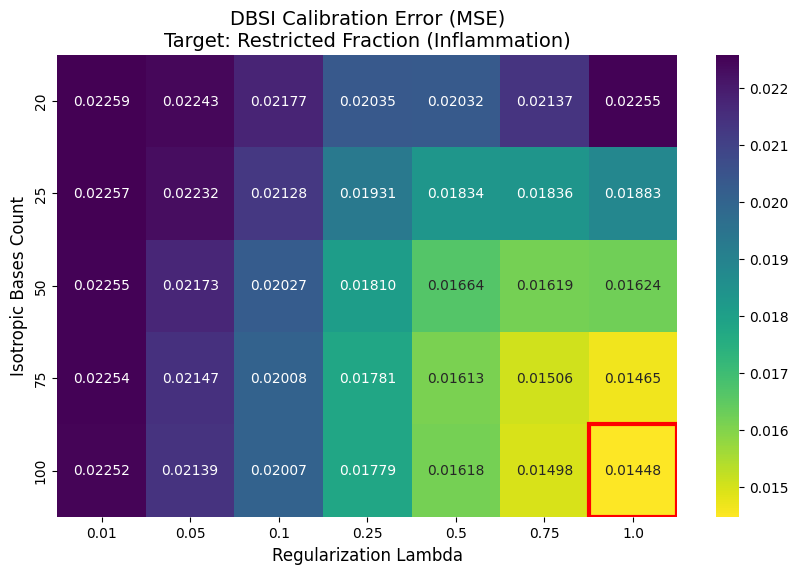

In [ ]:
from dbsi_optimized import DBSI_FastModel, estimate_snr_robust
from dbsi_optimized.calibration import run_hyperparameter_optimization

print("SNR Estimation...\n")

snr_result = estimate_snr_robust(dwi, bvals, mask)

print(f" SNR:")
print(f" SNR final: {snr_result['snr']:.2f}")
print(f" Method: {snr_result['method_used']}")


opt_params = run_hyperparameter_optimization(
    bvals=bvals,
    bvecs=bvecs,
    snr=snr_result['snr'],
    seed=42, #fixed seed for reproducibility
    plot=True
)

from dbsi_optimized import plot_design_matrix

print("\n Desing Matrix Visual Inspection:")

plot_design_matrix(
    bvals=bvals,
    bvecs=bvecs,
    n_iso_bases=opt_params['best_n_bases'], # Usa il valore ottimizzato!
    # Puoi anche passare D_ax e D_rad se li hai personalizzati
)


🔍 Ispezione Visuale della Matrice di Design:


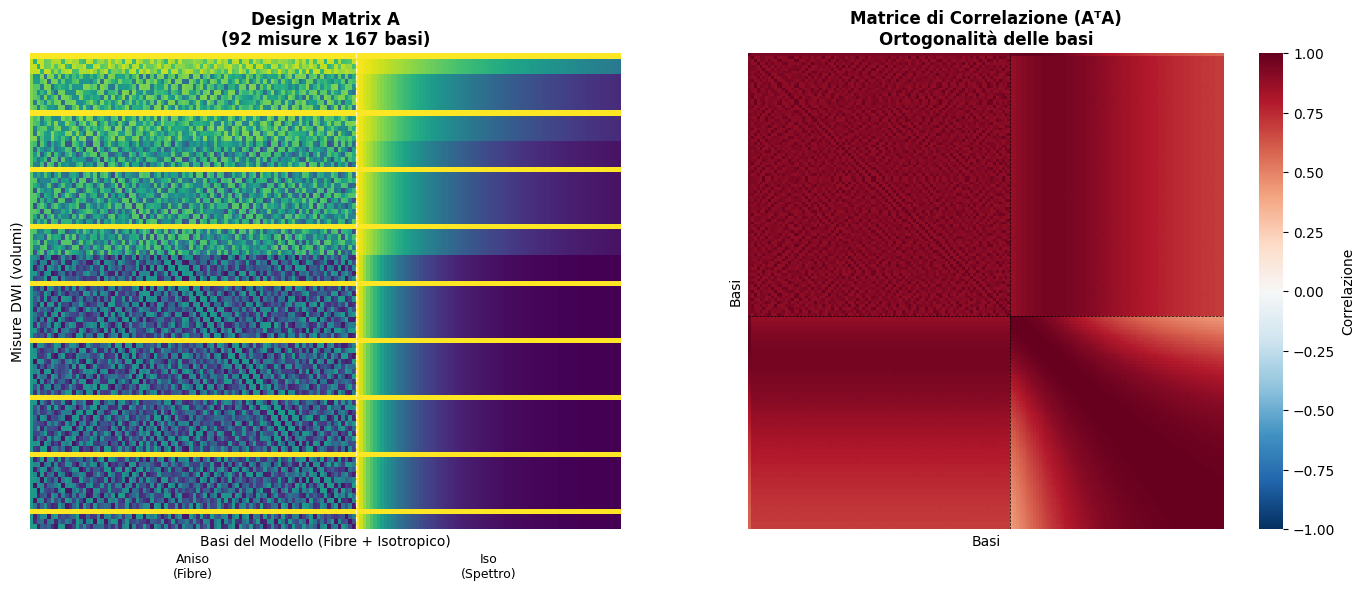

📊 Info Matrice:
   Shape: (92, 167)
   Condizionamento (Condition Number): 2.89e+17
   ⚠️ Attenzione: Matrice mal condizionata! La regolarizzazione è essenziale.


In [3]:
from dbsi_optimized import plot_design_matrix

print("\n🔍 Ispezione Visuale della Matrice di Design:")

plot_design_matrix(
    bvals=bvals,
    bvecs=bvecs,
    n_iso_bases=opt_params['best_n_bases'], # Usa il valore ottimizzato!
    # Puoi anche passare D_ax e D_rad se li hai personalizzati
)

---
## 4. Fitting DBSI

Ora eseguiamo il fitting DBSI completo:

In [5]:
# Inizializza modello
model = DBSI_FastModel(
    n_iso_bases=50,      # Numero di basi isotrope
    reg_lambda=0.1,      # Regolarizzazione
    n_jobs=-1,            # 1=seriale, -1=tutti i CPU
    verbose=True         # Mostra progresso
)

print("\n📊 Parametri modello:")
print(f"   Basi isotrope: {model.n_iso_bases}")
print(f"   Lambda: {model.reg_lambda}")
print(f"   D_axial: {model.D_ax*1e3:.2f} × 10⁻³ mm²/s")
print(f"   D_radial: {model.D_rad*1e3:.2f} × 10⁻³ mm²/s")


📊 Parametri modello:
   Basi isotrope: 50
   Lambda: 0.1
   D_axial: 1.50 × 10⁻³ mm²/s
   D_radial: 0.30 × 10⁻³ mm²/s


In [6]:
# Esegui fitting
import time

print("\n🔄 Avvio fitting DBSI...\n")
start_time = time.time()

results = model.fit(
    dwi_volume=dwi,
    bvals=bvals,
    bvecs=bvecs,
    mask=mask,
    snr=snr_result['snr']  # Usa SNR stimato
)

elapsed = time.time() - start_time
print(f"\n Tempo totale: {elapsed:.1f} secondi")
print(f"\n Tempo per voxel: {elapsed/np.sum(mask)*1000:.2f} ms")


🔄 Avvio fitting DBSI...



TypeError: DBSI_FastModel.fit() got an unexpected keyword argument 'dwi_volume'

In [ ]:
# Riepilogo qualità
quality = results.get_quality_summary()

print("\n📊 Riepilogo Qualità:")
print(f"   R² medio: {quality['mean_r_squared']:.3f}")
print(f"   R² mediano: {quality['median_r_squared']:.3f}")
print(f"   Fiber fraction media: {quality['mean_fiber_fraction']:.3f}")
print(f"   Restricted fraction media: {quality['mean_restricted_fraction']:.3f}")

---
## 5. Visualizzazione Risultati

Visualizziamo le mappe DBSI ottenute:

In [ ]:
# Visualizza mappe DBSI
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
slice_idx = results.shape[2] // 2

# Fiber Fraction
ax = axes[0, 0]
im = ax.imshow(results.fiber_fraction[:, :, slice_idx].T, 
               cmap='hot', origin='lower', vmin=0, vmax=1)
ax.set_title('Fiber Fraction\n(Densità assonale)', fontsize=12)
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046)

# Restricted Fraction (INFIAMMAZIONE)
ax = axes[0, 1]
im = ax.imshow(results.restricted_fraction[:, :, slice_idx].T, 
               cmap='Reds', origin='lower', vmin=0, vmax=0.5)
ax.set_title('Restricted Fraction\n⚠️ MARKER INFIAMMAZIONE', fontsize=12, color='darkred')
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046)

# Hindered Fraction
ax = axes[0, 2]
im = ax.imshow(results.hindered_fraction[:, :, slice_idx].T, 
               cmap='Blues', origin='lower', vmin=0, vmax=1)
ax.set_title('Hindered Fraction\n(Edema)', fontsize=12)
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046)

# Water Fraction
ax = axes[1, 0]
im = ax.imshow(results.water_fraction[:, :, slice_idx].T, 
               cmap='cyan', origin='lower', vmin=0, vmax=0.5)
ax.set_title('Water Fraction\n(Atrofia/CSF)', fontsize=12)
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046)

# R-squared (quality)
ax = axes[1, 1]
im = ax.imshow(results.r_squared[:, :, slice_idx].T, 
               cmap='viridis', origin='lower', vmin=0, vmax=1)
ax.set_title('R² (Qualità fit)', fontsize=12)
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046)

# Composito RGB
ax = axes[1, 2]
rgb = np.zeros((*results.fiber_fraction[:, :, slice_idx].shape, 3))
rgb[:, :, 0] = results.restricted_fraction[:, :, slice_idx]  # Red = Inflammation
rgb[:, :, 1] = results.fiber_fraction[:, :, slice_idx]       # Green = Fiber
rgb[:, :, 2] = results.hindered_fraction[:, :, slice_idx]    # Blue = Edema
rgb = np.clip(rgb * 2, 0, 1)  # Aumenta contrasto
ax.imshow(np.transpose(rgb, (1, 0, 2)), origin='lower')
ax.set_title('Composito RGB\nR=Infiamm, G=Fiber, B=Edema', fontsize=12)
ax.axis('off')

plt.suptitle(f'Mappe DBSI - Slice {slice_idx}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Istogrammi delle frazioni
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

fractions = [
    ('Fiber', results.fiber_fraction, 'orange'),
    ('Restricted', results.restricted_fraction, 'red'),
    ('Hindered', results.hindered_fraction, 'blue'),
    ('Water', results.water_fraction, 'cyan'),
]

for ax, (name, data, color) in zip(axes, fractions):
    values = data[mask]
    ax.hist(values, bins=50, color=color, alpha=0.7, edgecolor='white')
    ax.axvline(np.mean(values), color='black', linestyle='--', 
               label=f'Media: {np.mean(values):.3f}')
    ax.set_xlabel('Fraction')
    ax.set_ylabel('Count')
    ax.set_title(f'{name} Fraction')
    ax.legend()

plt.tight_layout()
plt.show()

---
## 6. Salvataggio Risultati

Salva le mappe come file NIfTI:

In [ ]:
# Salva risultati
output_dir = 'dbsi_results'

# Crea matrice affine di default (per dati sintetici)
affine = np.eye(4)

results.save(output_dir, affine=affine, prefix='dbsi')

print(f"\n📁 File salvati in '{output_dir}/':")
import os
for f in sorted(os.listdir(output_dir)):
    size = os.path.getsize(os.path.join(output_dir, f)) / 1024
    print(f"   {f} ({size:.1f} KB)")

---
## 7. Caricamento Dati Reali (Opzionale)

Se hai dati reali, puoi caricarli così:

In [ ]:
# Template per dati reali (decommenta e modifica i path)

# from dbsi_optimized.preprocessing import load_dwi_data

# dwi_real, bvals_real, bvecs_real, mask_real, affine_real = load_dwi_data(
#     nifti_file='path/to/dwi.nii.gz',
#     bval_file='path/to/dwi.bval',
#     bvec_file='path/to/dwi.bvec',
#     mask_file='path/to/mask.nii.gz'
# )

# # Fitting
# model = DBSI_FastModel(n_jobs=4, verbose=True)
# results_real = model.fit(dwi_real, bvals_real, bvecs_real, mask_real)
# results_real.save('real_dbsi_results/', affine_real)

print("ℹ️ Decommenta e modifica i path per usare i tuoi dati reali")

---
## 8. Interpretazione Clinica delle Mappe DBSI

| Mappa | Interpretazione | Range Tipico |
|-------|-----------------|---------------|
| **Fiber Fraction** | Densità assonale / integrità WM | 0.3-0.8 (WM sana) |
| **Restricted Fraction** | **Cellularità / Infiammazione** | <0.1 normale, >0.2 patologico |
| **Hindered Fraction** | Edema vasogenico | 0.1-0.4 |
| **Water Fraction** | CSF / Atrofia tissutale | <0.1 (WM), >0.5 (CSF) |
| **Axial Diffusivity** | Integrità assonale | ~1.5 × 10⁻³ mm²/s |
| **Radial Diffusivity** | Integrità mielinica | ~0.3 × 10⁻³ mm²/s |

### ⚠️ Marker Chiave per Neuroinfiammazione

La **Restricted Fraction** è il marker principale per l'infiammazione:
- Valori elevati indicano infiltrazione cellulare (cellule immunitarie, glia attivata)
- Correlata con densità cellulare in studi istologici
- Utile per distinguere infiammazione da danno assonale nella SM

---
## 📚 Riferimenti

1. Wang et al. (2011). "Quantification of increased cellularity during inflammatory demyelination." Brain.
2. Cross & Song (2017). "A new imaging modality to non-invasively assess multiple sclerosis pathology." J Neuroimmunol.
3. Ye et al. (2020). "Deep learning with DBSI for classification of MS lesions." Ann Clin Transl Neurol.

---

**🎉 Tutorial completato!**